## Similarity-based RUL Prediction

In [1]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time
import os
os.chdir("C:/Data/aircraft/")

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight

from scipy import optimize

In [2]:
def prepare_data():
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)

    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index + 1
    
    return df_train, df_test, y_true

In [8]:
df_train, df_test, y_true = prepare_data()
df_train.shape, df_test.shape, y_true.shape

((20631, 27), (13096, 26), (100, 2))

In [9]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [10]:
sc = MinMaxScaler(feature_range=(0,1))

df_train[feats] = sc.fit_transform(df_train[feats])
df_test[feats] = sc.transform(df_test[feats])

In [11]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,RUL
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187


In [12]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377


### Selecting features using Trendability

\begin{equation*}
Trendability \ (x) = \underset{j, k}{min} \ |corr(x_j, x_k)|
\end{equation*}

Where j and k are different units. To measure trendability I will consider last 50 observations and check correlation among various units.

In [110]:
def trendability(col):
    dff = df_train[['UnitNumber','Cycle',col]].sort_values(by=['UnitNumber','Cycle'],axis=0).groupby(['UnitNumber']).tail(128)

    dff['Cycle'] = dff.groupby(['UnitNumber']).rank()
    dff = dff.pivot(index='Cycle',columns='UnitNumber', values=col).reset_index(drop=True)
    
    cor = np.abs(dff.corr().values.min())
    
    return cor

In [111]:
trend_df = pd.DataFrame(columns = ['feature', 'trendability_val'])

for col in feats:
    trend_df = trend_df.append({'feature': col, 'trendability_val': trendability(col)}, ignore_index = True)

In [112]:
trend_df = trend_df.sort_values(by = 'trendability_val', ascending = False)
trend_df.head()

,feature,trendability_val
16,SensorMeasure14,0.942066
11,SensorMeasure9,0.871676
13,SensorMeasure11,0.598265
6,SensorMeasure4,0.518832
14,SensorMeasure12,0.497372


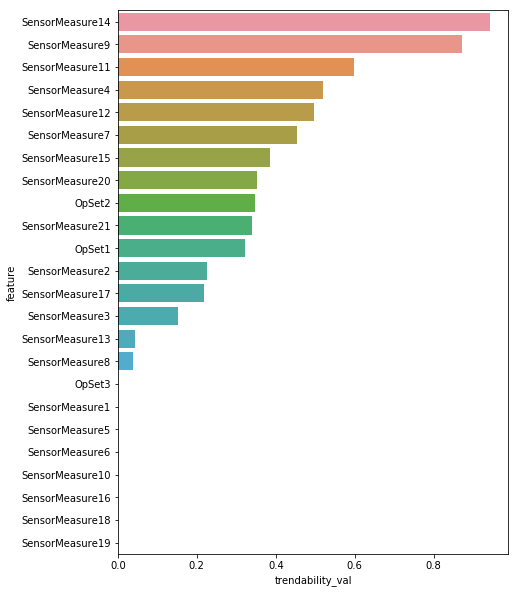

In [113]:
fig, ax = plt.subplots(figsize = (7,10))

sns.barplot(y = trend_df.feature, x = trend_df.trendability_val)